In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from tabulate import tabulate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Ladda in datasetet
data = pd.read_csv('./data/IMDB Dataset.csv')
# Define the percentage of data you want to sample (e.g., 10%)
sample_percentage = 10

# Use the sample method to randomly select a subset of your data
sampled_data = data.sample(frac=sample_percentage/100, random_state=42)



In [3]:
# Kolla om det finns null-värden i datasetet
null_count = data.isnull().sum()

# Skriv ut antalet null-värden i varje kolumn
print(null_count)

# Alternativt kan du skriva ut de första raderna som innehåller null-värden
print(data[data.isnull().any(axis=1)])
# Visa statistiska sammanfattningar för numeriska kolumner
print(data.describe())
data_types = data.dtypes
print(data_types)


antal_exempel = len(data)

review       0
sentiment    0
dtype: int64
Empty DataFrame
Columns: [review, sentiment]
Index: []
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
review       object
sentiment    object
dtype: object


In [4]:

# Använd .unique() för att hämta de unika värdena i 'sentiment'-kolumnen.
unique_labels = data['sentiment'].unique()

# Kontrollera om det finns exakt två unika etiketter, 'positive' och 'negative'.
if len(unique_labels) == 2 and 'positive' in unique_labels and 'negative' in unique_labels:
    print("Ditt dataset innehåller exakt två unika etiketter: 'positive' och 'negative'.")
else:
    print("Ditt dataset innehåller inte exakt två unika etiketter: 'positive' och 'negative'.")

Ditt dataset innehåller exakt två unika etiketter: 'positive' och 'negative'.


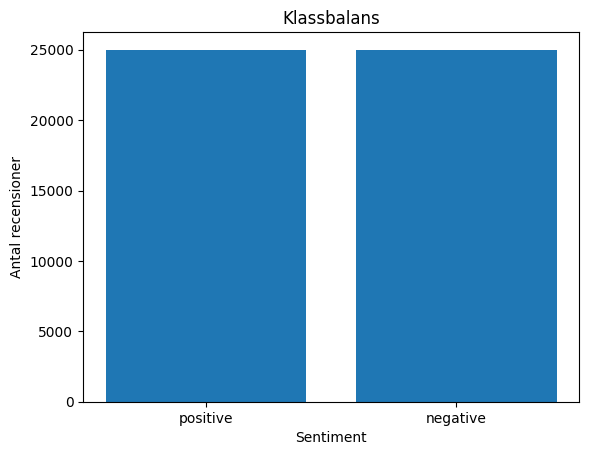

In [5]:

# Visualisera balansen mellan positiva och negativa recensioner
class_distribution = data['sentiment'].value_counts()

plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Sentiment')
plt.ylabel('Antal recensioner')
plt.title('Klassbalans')
plt.show()


In [6]:
# Dela upp datasetet i positiva och negativa recensioner
positive_reviews = data[data['sentiment'] == 'positive']
negative_reviews = data[data['sentiment'] == 'negative']

# Funktion för textförberedelse

In [8]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text):
    # Ta bort specialtecken
    translation_table = str.maketrans('', '', string.punctuation)
    text = text.translate(translation_table)
    
    # Omvandla text till små bokstäver
    text = text.lower()
    
    # Ta bort <br />, webbadresser, @-taggar och hashtaggar
    text = re.sub ('br', '',text)
    text = re.sub('<br>', ' ', text) 
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Ta bort icke-ordtecken
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenisera texten
    text_tokens = word_tokenize(text)
    
    # Ta bort stoppord
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in text_tokens if word not in stop_words]
    
    return " ".join(filtered_text)


In [11]:
# Tillämpa preprocess_text-funktionen på recensionerna
positive_reviews.loc[:, 'cleaned_review'] = positive_reviews['review'].apply(preprocess_text)
negative_reviews.loc[:, 'cleaned_review'] = negative_reviews['review'].apply(preprocess_text)

In [12]:
# Skapa ordlistor för positiva och negativa recensioner efter preprocessing
positive_word_list = nltk.word_tokenize(' '.join(positive_reviews['cleaned_review']))
positive_word_list = [word for word in positive_word_list if word not in stopwords.words('english')]

negative_word_list = nltk.word_tokenize(' '.join(negative_reviews['cleaned_review']))
negative_word_list = [word for word in negative_word_list if word not in stopwords.words('english')]

In [13]:
# Skapa och skriv ut de mest förekommande orden för både positiva och negativa recensioner
most_common_positive_words = Counter(positive_word_list).most_common(15)
most_common_negative_words = Counter(negative_word_list).most_common(15)

In [14]:
# Skriv ut resultaten med tabulate
print("Most Common Positive Words:")
print(tabulate(most_common_positive_words, headers=['Ord', 'Frekvens']))

print("\nMost Common Negative Words:")
print(tabulate(most_common_negative_words, headers=['Ord', 'Frekvens']))

Most Common Positive Words:
Ord       Frekvens
------  ----------
film         40164
movie        36704
one          26293
like         17181
good         14572
great        12810
story        12610
time         12124
see          11986
well         11407
also         10727
really       10718
would        10383
even          9484
much          9096

Most Common Negative Words:
Ord       Frekvens
------  ----------
movie        48521
film         35866
one          25183
like         21883
even         15099
bad          14362
good         14340
would        13653
really       12293
time         11843
see          10654
dont         10279
get          10034
much         10014
story         9904


In [15]:
# Skapa en kolumn 'cleaned_review' i din ursprungliga DataFrame 'data'
data['cleaned_review'] = ''

# Fyll 'cleaned_review' med preprocessade recensioner från positiva och negativa DataFrames
data.loc[data['sentiment'] == 'positive', 'cleaned_review'] = positive_reviews['cleaned_review']
data.loc[data['sentiment'] == 'negative', 'cleaned_review'] = negative_reviews['cleaned_review']



In [20]:
# Skapa histogram för de mest använda orden i positiva recensioner
positive_words = ' '.join(positive_reviews['cleaned_review'])
positive_word_list = nltk.word_tokenize(positive_words)
positive_word_list = [word for word in positive_word_list if word not in stopwords.words('english')]

positive_word_counts = Counter(positive_word_list)
most_common_positive_words = positive_word_counts.most_common(20)  # De 20 mest använda orden


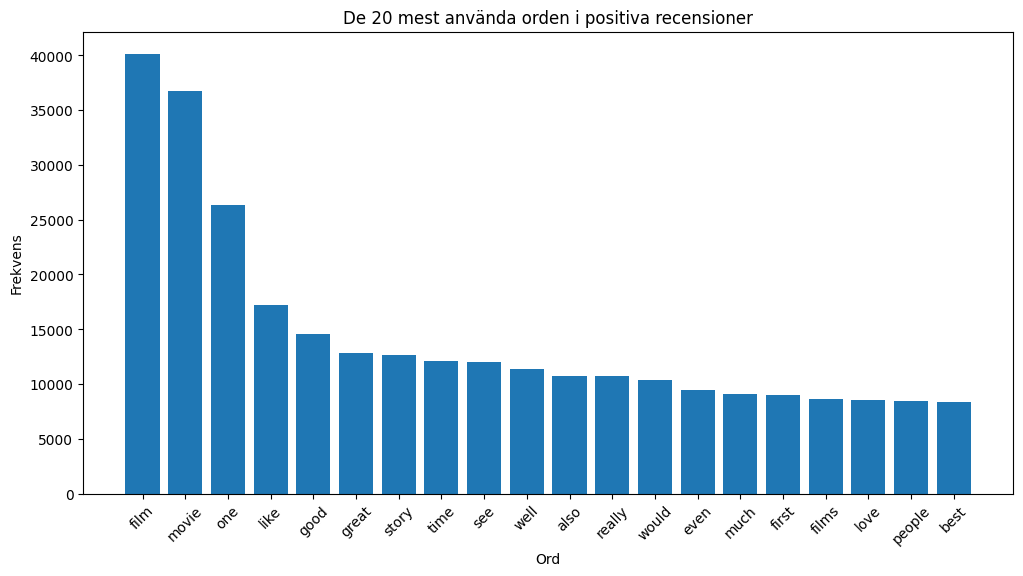

In [21]:
# Skapa histogram för de 20 mest använda orden i positiva recensioner
most_common_positive_words = positive_word_counts.most_common(20)

# Dela upp de mest använda orden och deras frekvenser
words, word_counts = zip(*most_common_positive_words)

# Skapa ett histogram
plt.figure(figsize=(12, 6))
plt.bar(words, word_counts)
plt.xlabel('Ord')
plt.ylabel('Frekvens')
plt.title('De 20 mest använda orden i positiva recensioner')
plt.xticks(rotation=45)  # Roterar x-axeln för bättre läsbarhet
plt.show()

In [22]:
# Skapa histogram för de mest använda ord i negativa recensioner
negative_words = ' '.join(negative_reviews['cleaned_review'])
negative_word_list = nltk.word_tokenize(negative_words)
negative_word_list = [word for word in negative_word_list if word not in stopwords.words('english')]

negative_word_counts = Counter(negative_word_list)
most_common_negative_words = negative_word_counts.most_common(20)

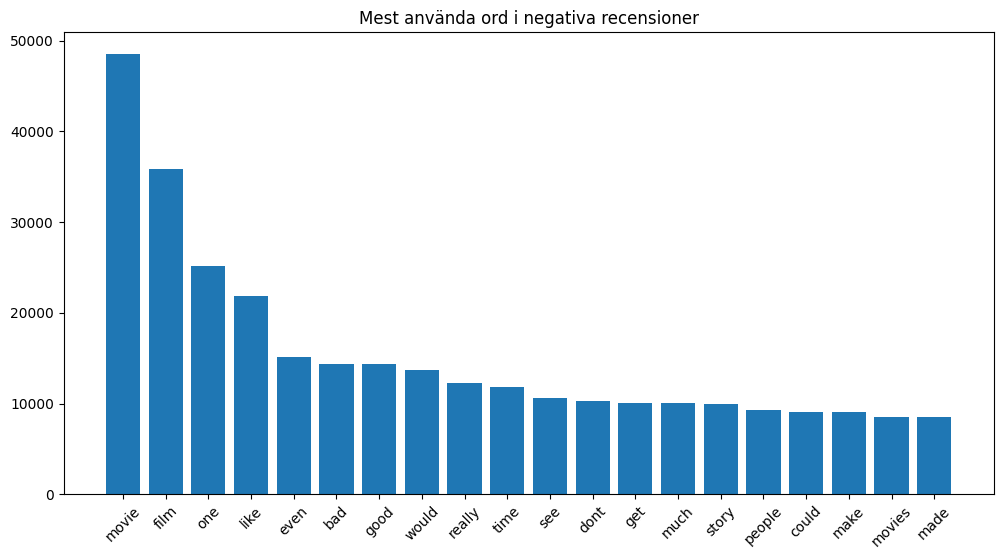

In [23]:
# Skapa och visa histogram för negativa recensioner
plt.figure(figsize=(12, 6))
plt.bar(*zip(*most_common_negative_words))
plt.title('Mest använda ord i negativa recensioner')
plt.xticks(rotation=45)
plt.show()


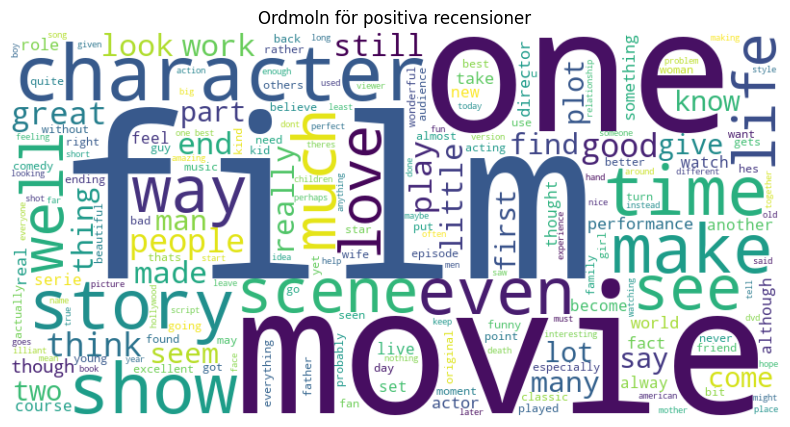

In [24]:
# Skapa ordmoln för positiva recensioner
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Ordmoln för positiva recensioner')
plt.show()

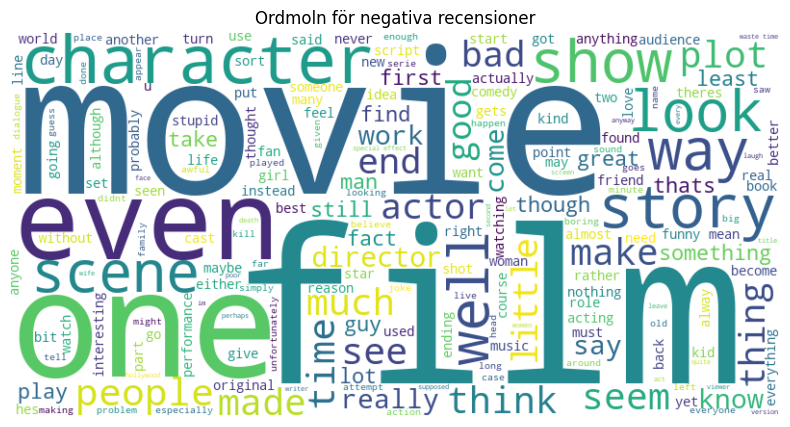

In [25]:
# Skapa ordmoln för negativa recensioner
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Ordmoln för negativa recensioner')
plt.show()

In [26]:
# Dela upp datasetet i tränings- och testdata
X = data['cleaned_review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Skapa TF-IDF-vektorer för texten
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [28]:
from sklearn.preprocessing import MaxAbsScaler

# Hantera extrema värden med MaxAbs-scaling
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

In [29]:
# Träna och utvärdera modeller
models = {
    'Logistic Regression': LogisticRegression(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Linear Support Vector Classifier': LinearSVC()
}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Classification Report:\n{report}\n')

Model: Logistic Regression
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Model: Multinomial Naive Bayes
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4961
    positive       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000




C:\Users\amand\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Model: Linear Support Vector Classifier
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000




**Logistic Regression:**
- Träningsnoggrannhet (Accuracy): 0.89
- Classification Report:
    - Precision för negativa recensioner: 0.90
    - Precision för positiva recensioner: 0.88
    - Recall (återkallande) för negativa recensioner: 0.87
    - Recall för positiva recensioner: 0.90
    - F1-score för negativa recensioner: 0.89
    - F1-score för positiva recensioner: 0.89

**Multinomial Naive Bayes:**
- Träningsnoggrannhet (Accuracy): 0.85
- Classification Report:
    - Precision för negativa recensioner: 0.85
    - Precision för positiva recensioner: 0.85
    - Recall för negativa recensioner: 0.85
    - Recall för positiva recensioner: 0.86
    - F1-score för negativa recensioner: 0.85
    - F1-score för positiva recensioner: 0.85

**Linear Support Vector Classifier:**
- Träningsnoggrannhet (Accuracy): 0.88
- Classification Report:
    - Precision för negativa recensioner: 0.89
    - Precision för positiva recensioner: 0.88
    - Recall för negativa recensioner: 0.87
    - Recall för positiva recensioner: 0.90
    - F1-score för negativa recensioner: 0.88
    - F1-score för positiva recensioner: 0.89

Det verkar som att Logistic Regression-modellen presterar bäst med en noggrannhet på 0.89 och balanserade värden för precision, recall och F1-score för både negativa och positiva recensioner. Linear Support Vector Classifier ligger också nära med en noggrannhet på 0.88. Multinomial Naive Bayes har något lägre noggrannhet på 0.85.


In [30]:
# Exempel på tolkning av modellresultat
model = models['Logistic Regression']  # Ersätt 'Logistic Regression' med namnet på den modell du vill använda
sample_review = "This movie is amazing."

# Använd din preprocessningsfunktion på recensionen
sample_review = preprocess_text(sample_review)

# Omvandla texten till en vektor med din vektoriseringsmetod (tfidf_vectorizer)
sample_review_vector = tfidf_vectorizer.transform([sample_review])

# Gör förutsägelser med din valda modell
probabilities = model.predict_proba(sample_review_vector)
positive_prob = probabilities[0][1]
negative_prob = probabilities[0][0]

if positive_prob > 0.7:
    print("Recensionen är positiv.")
elif negative_prob > 0.7:
    print("Recensionen är negativ.")
else:
    print("Svårt att klassificera recensionen.")

Recensionen är positiv.


In [31]:
# Exempel på tolkning av modellresultat
model = models['Logistic Regression']  # Ersätt 'Logistic Regression' med namnet på den modell du vill använda
sample_review = "I dont believe it."

# Använd din preprocessningsfunktion på recensionen
sample_review = preprocess_text(sample_review)

# Omvandla texten till en vektor med din vektoriseringsmetod (tfidf_vectorizer)
sample_review_vector = tfidf_vectorizer.transform([sample_review])

# Gör förutsägelser med din valda modell
probabilities = model.predict_proba(sample_review_vector)
positive_prob = probabilities[0][1]
negative_prob = probabilities[0][0]

if positive_prob > 0.7:
    print("Recensionen är positiv.")
elif negative_prob > 0.7:
    print("Recensionen är negativ.")
else:
    print("Svårt att klassificera recensionen.")

Recensionen är negativ.
